In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

In [2]:
preprocessed_train_set = pd.read_csv('data/preprocessed_train_set.csv', sep=';')
train_target = pd.read_csv('data/train_target.csv', sep=';')

preprocessed_test_set = pd.read_csv('data/preprocessed_test_set.csv', sep=';')
test_target = pd.read_csv('data/test_target.csv', sep=';')

In [3]:
ids = ['application_id','customer_id']

train_ids = preprocessed_train_set[ids]
test_ids = preprocessed_test_set[ids]

preprocessed_train_set = preprocessed_train_set.drop(ids, 1)
preprocessed_test_set = preprocessed_test_set.drop(ids, 1)

In [4]:
final_model = RandomForestClassifier(
    n_estimators=2250, 
    max_depth=21,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=6,
    class_weight='balanced')

In [5]:
# Training
final_model.fit(preprocessed_train_set, train_target)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=21, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2250, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [6]:
#Prediction
prediction = final_model.predict(preprocessed_test_set)

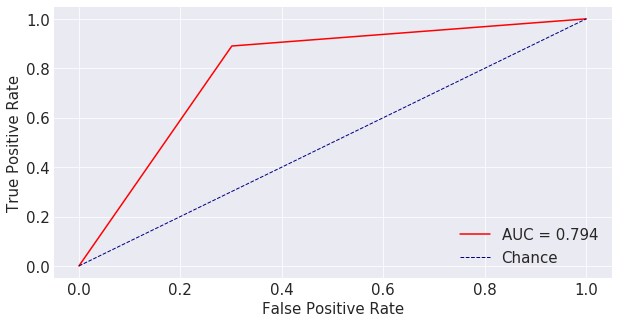

In [7]:
# Plot ROC

def plot_roc(target, predicted_proba):
    fpr, tpr, _ = roc_curve(target, predicted_proba)
    auc_plot = roc_auc_score(target, predicted_proba)
    
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, '-',  color='red', lw=1.5, label='AUC = %0.3f' % auc_plot)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance')

    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plot_roc(test_target, prediction)   

# Cross Validation

In [8]:
cv_model = RandomForestClassifier(
    n_estimators=2250, 
    max_depth=21,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=6,
    class_weight='balanced')

In [9]:
preprocessed_entire_set = pd.read_csv('data/preprocessed_entire_set.csv', sep=';')
entire_target = pd.read_csv('data/entire_target.csv', sep=';')

ids = ['application_id','customer_id']

preprocessed_entire_set = preprocessed_entire_set.drop(ids, 1)

nfold = 5
cv = StratifiedKFold(n_splits=nfold, random_state=2019, shuffle=True)
auc_sum = 0  
for (train, test), i in zip(cv.split(preprocessed_entire_set, entire_target), range(nfold)):
    cv_model.fit(preprocessed_entire_set.iloc[train], entire_target.iloc[train])
    y_predict = cv_model.predict(preprocessed_entire_set.iloc[test])
    auc = roc_auc_score(entire_target.iloc[test], y_predict)
    auc_sum += auc

print float(auc_sum)/nfold

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


0.789641915095


# Final Training + Prediction 

In [10]:
preprocessed_entire_set = pd.read_csv('data/preprocessed_entire_set.csv', sep=';')
entire_target = pd.read_csv('data/entire_target.csv', sep=';')

ids = ['application_id','customer_id']

preprocessed_entire_set = preprocessed_entire_set.drop(ids, 1)

In [11]:
final_model = RandomForestClassifier(
    n_estimators=2250, 
    max_depth=21,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=6,
    class_weight='balanced')

In [12]:
final_model.fit(preprocessed_entire_set, np.ravel(entire_target))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=21, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2250, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [13]:
ferratum_preprocessed_test_set = pd.read_csv('data/ferratum_preprocessed_test_set.csv', sep=';')
ferratum_preprocessed_test_set = ferratum_preprocessed_test_set.drop(ids, 1)
ferratum_preprocessed_test_set = ferratum_preprocessed_test_set.drop(['Target'], 1)

In [14]:
final_prediction = final_model.predict_proba(ferratum_preprocessed_test_set)

In [15]:
result = pd.DataFrame(final_prediction, columns=['PROBABILITY_CLASS_0','PROBABILTY_CLASS_1'])

In [16]:
result.shape

(515, 2)

In [17]:
result.head()

,PROBABILITY_CLASS_0,PROBABILTY_CLASS_1
0,0.289664,0.710336
1,0.255965,0.744035
2,0.544578,0.455422
3,0.206427,0.793573
4,0.508933,0.491067


In [18]:
result[['PROBABILTY_CLASS_1']].to_csv('data/probability_class_1.csv', sep=';', index=False)

In [19]:
pickle.dump(
    final_prediction, 
    open('data/final_model.pkl', 'wb'))